<a href="https://colab.research.google.com/github/Sathishk2/Computer-Vision/blob/main/CNN_cats_dogs_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ex: Cats and Dogs (Transfer Learning)**

In [ ]:
import tensorflow as tf
print(tf.__version__)

#
# Check if we got GPU
#
print(tf.test.gpu_device_name()) #Returns the name of a GPU device if available

2.14.0
/device:GPU:0


In [ ]:
#
# Mount drive to connect to Google Drive (for accessing input data file)
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Step 1 Prepare Data#

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# (inside the zipped folder)
# cats_and_dogs_filtered
#          |
#          |- train
#          |    |- cats (1000 jpgs of cats)
#          |    |- dogs (1000 jpgs of dogs)
#          |
#          |- validation
#               |- cats (500 jpgs of cats)
#               |- dogs (500 jpgs of dogs)
#
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# get the file from _URL and extract contents out in temp folder
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip) #the zip file downloaded to temp folder

# cats_and_dogs_filtered folder zipped inside zip file
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)

68606236/68606236 [==============================] - 1s 0us/step
/root/.keras/datasets/cats_and_dogs.zip
/root/.keras/datasets/cats_and_dogs_filtered


In [ ]:
train_dir = os.path.join(PATH, 'train') # training folder
validation_dir = os.path.join(PATH, 'validation') # validation folder
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [ ]:
print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
# Define some constants
BATCH_SIZE = 100
EPOCHS = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# Create ImageDataGenerator objects with transformation parameters
# we only add additional transformations to the training ImageDataGenerator

train_image_generator = ImageDataGenerator(
                    rescale=1.0/255.0,
                    rotation_range=45, #randomly rotate image in degree (0 to 180)
                    width_shift_range=0.15, # randomly shift images horizontally 15%
                    height_shift_range=0.15, # randomly shift images vertically 15%
                    horizontal_flip=True,
                    zoom_range=0.5, # Randomly zoom image by up to 50%
	                  vertical_flip=False
                    )

validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Images are flowed from directory with specified BATCH_SIZE
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# cats=0, dogs=1, based on folder names in alphabetical order
print(train_data_gen.class_indices)
print(val_data_gen.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


#Step 2 Build Model#

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Define model using pre-trained VGG16 in functional mode
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
x=base_model.output
#x=GlobalAveragePooling2D()(x) #helps to flatten, x=Flatten()(x) should give a better result but may take longer
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

In [ ]:
# Freeze the base layers
base_model.trainable = False

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_1 True
dense_6 True
dense_7 True
dense_8 True


In [ ]:
#
# Unfreezing Block 5
# It may turn out to be worse
# Need further investigation
#
for layer in base_model.layers[-4:]:
  layer.trainable = True

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_1 True
dense_6 True
dense_7 True
dense_8 True


In [ ]:
#
# Specify optimizer, loss function and metrics during compilation
#
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']) # "accuracy" is for evaluating model performance

#Step 3 & 4 Train & Evaluate Model#

In [ ]:
#steps per epoch means number of batches used per epoch. It is
#the number of batch iterations before a training epoch is considered finished.
#
#use this to calculate: steps_per_epoch = (len(train data) // batch_size)
#                       validation_steps = (len(validate data) // batch_size)
#
# steps_per_epoch = 2000 samples per epoch // 100 per batch = 20 batches per epoch
# validation_steps = 1000 samples per epoch // 100 per batch = 10 batches per epoch
#
#Keep in mind that the data generator is meant to loop indefinitely.
#Since the function is intended to loop indefinitely, tf has no ability to determine when one epoch starts and a new epoch begins.
#So, we compute the steps_per_epoch value as number of batches to be processed before counting as an epoch. Similar for validation.
#Once tf hits this step count, it knows that it’s a new epoch (think of it as major and minor epoch)
#
history = model.fit(
      train_data_gen,    #which gen to use for training
      steps_per_epoch=20, #no of training batches per epoch
      epochs=EPOCHS,
      validation_data=val_data_gen, #which gen to use for testing
      validation_steps=10) #no of validation batches per epoch

Epoch 1/15
20/20 [==============================] - 20s 927ms/step - loss: 1.4554 - accuracy: 0.5745 - val_loss: 0.4255 - val_accuracy: 0.8120
Epoch 2/15
20/20 [==============================] - 21s 1s/step - loss: 0.4691 - accuracy: 0.7825 - val_loss: 0.3147 - val_accuracy: 0.8620
Epoch 3/15
20/20 [==============================] - 18s 913ms/step - loss: 0.4130 - accuracy: 0.8065 - val_loss: 0.2809 - val_accuracy: 0.8750
Epoch 4/15
20/20 [==============================] - 18s 915ms/step - loss: 0.3979 - accuracy: 0.8095 - val_loss: 0.2888 - val_accuracy: 0.8740
Epoch 5/15
20/20 [==============================] - 21s 1s/step - loss: 0.4402 - accuracy: 0.7850 - val_loss: 0.3370 - val_accuracy: 0.8550
Epoch 6/15
20/20 [==============================] - 20s 1s/step - loss: 0.4266 - accuracy: 0.7990 - val_loss: 0.2881 - val_accuracy: 0.8690
Epoch 7/15
20/20 [==============================] - 18s 918ms/step - loss: 0.3920 - accuracy: 0.8185 - val_loss: 0.2660 - val_accuracy: 0.8810
Epoch 8/

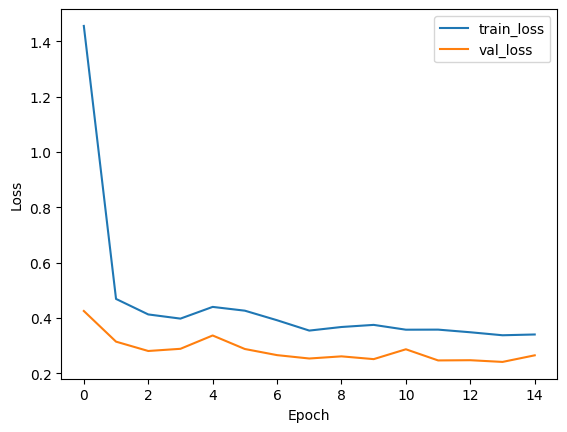

In [ ]:
#
# Visualization of Loss and Accuracy
#
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(len(loss))

plt.plot(epoch, loss, label='train_loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

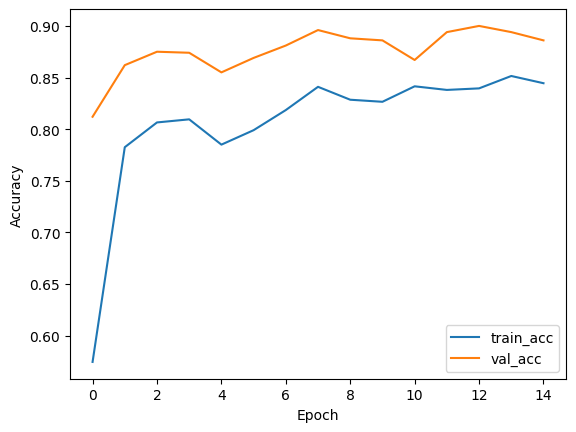

In [ ]:
plt.plot(epoch, acc, label='train_acc')
plt.plot(epoch, val_acc, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#
# Save Model
#
model.save('/content/drive/MyDrive/app/cats_dogs_cnn_tf.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Step 5 Make Prediction#

In [ ]:
#
# Note: we didn't do any saving and loading here
#       we use the trained model directly
#
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

#
# dog images for validation stored at validation_dogs_dir
#
object=['cat','dog']

for p in range(10):
  img = load_img(path=validation_dogs_dir+'/dog.'+str(2000+p)+'.jpg', color_mode="rgb", target_size=(150,150))
  imgArray = img_to_array(img) #convert to numpy array
  imgInput = imgArray.reshape(1,150,150,3)/255.0

  predictions = model.predict(imgInput)
  print("%s %.4f %s" % ('dog.'+str(2000+p)+'.jpg:', predictions[0][1], object[int(predictions[0][1]>0.5)])) # cat=0, dog=1

1/1 [==============================] - 1s 660ms/step
dog.2000.jpg: 0.9943 dog
1/1 [==============================] - 0s 22ms/step
dog.2001.jpg: 0.9999 dog
1/1 [==============================] - 0s 17ms/step
dog.2002.jpg: 0.9801 dog
1/1 [==============================] - 0s 17ms/step
dog.2003.jpg: 0.8337 dog
1/1 [==============================] - 0s 20ms/step
dog.2004.jpg: 0.9999 dog
1/1 [==============================] - 0s 20ms/step
dog.2005.jpg: 0.8565 dog
1/1 [==============================] - 0s 22ms/step
dog.2006.jpg: 0.6301 dog
1/1 [==============================] - 0s 18ms/step
dog.2007.jpg: 0.9795 dog
1/1 [==============================] - 0s 19ms/step
dog.2008.jpg: 1.0000 dog
1/1 [==============================] - 0s 20ms/step
dog.2009.jpg: 0.0040 cat
